In [ ]:
### install, import
!pip install keybert

# import
from google.colab import drive
drive.mount("/content/drive")
import numpy as np
import pandas as pd
import re
import math
from multiprocessing import Pool
# nlp
from keybert import KeyBERT
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
# sklearn
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
# torch
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
from torch.nn import Sequential, Module
from matplotlib import pyplot as plt
from scipy.stats import norm

### ***data import & preprocessing***
---

In [ ]:
### data import
path="/content/drive/MyDrive/DS5500_Project Capstone/dataset/main_dataset.csv"
df = pd.read_csv(path)
df2 = pd.read_csv(path, dtype={'HS_Code': object})

# preprocessing
df.drop_duplicates(inplace=True)

# preprocessing description df
df['Description'] = df['Description'].str.lower()
df['Description'] = df['Description'].apply(lambda x: x.split('hs code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hts code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hscode')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('h s code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hs-code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hs.code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('h.s.code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('htscode')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hts-code')[0])
df['Description'] = df['Description'].apply(lambda x: x.split('hts.code')[0])
df['Description'] = df['Description'].apply(lambda x: re.sub(r'\d{4}\.\d{2}','', x))
df['Description'] = df['Description'].apply(lambda x: re.sub(r'\d{6}|\d{10}','', x))
df['Description'] = df['Description'].str.replace('\W', ' ')

# preprocessing description df2
df2['Description'] = df2['Description'].str.lower()
df2['Description'] = df2['Description'].apply(lambda x: x.split('hs code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hts code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hscode')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('h s code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hs-code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hs.code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('h.s.code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('htscode')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hts-code')[0])
df2['Description'] = df2['Description'].apply(lambda x: x.split('hts.code')[0])
df2['Description'] = df2['Description'].apply(lambda x: re.sub(r'\d{4}\.\d{2}','', x))
df2['Description'] = df2['Description'].apply(lambda x: re.sub(r'\d{6}|\d{10}','', x))
df2['Description'] = df2['Description'].str.replace('\W', ' ')

In [ ]:
### word imbedding & keywords
### build model
# train test split
from sklearn.model_selection import train_test_split
df2.drop_duplicates(inplace=True)
df_train, df_val, y_train, y_val = train_test_split(df2, df2['HS_Code'], test_size=0.2)

# model
kw_model = KeyBERT('distilbert-base-nli-mean-tokens')

# apply model
df['Keyword_with_Scores'] = df['Description'].apply(lambda x: kw_model.extract_keywords(x,keyphrase_ngram_range=(1, 3),
                                                                                        stop_words='english', use_maxsum=True,
                                                                                        nr_candidates=20, top_n=5))
# extract keywords
def extract_keywords(keyword_score_list):
    phrase_list = []
    if isinstance(keyword_score_list,(list,tuple)):
        for keyword in keyword_score_list:
            if keyword[1] > 0.5:
                phrase_list.append(keyword[0])
        phrase_non_unique = " ".join(phrase_list)
        unique_words = set(phrase_non_unique.split(' '))
        phrase = " ".join(unique_words)

        return phrase
    else:
        return ""

# apply
df['Keywords'] = df['Keyword_with_Scores'].apply(extract_keywords)

# lower
df['Keywords'] = np.where(df['Keyword_with_Scores'].str.len() == 0, df['Description'].str.lower(), df['Keywords'])
df.head()

,HS_Code,Description,Keyword_with_Scores,Keywords
0,500100,disconnectors suitable for s3cd 362 1250,"[(suitable, 0.3382), (1250, 0.5676), (s3cd 362...",suitable s3cd 1250 362 disconnectors
8,500100,freight prepaid cargo is stowed in a refrigera...,"[(1840 bags kg, 0.3781), (firbinogen hc 500, 0...",plasma beef firbinogen
23,500100,705 ctn 12 488 dz prs 2700 dz prs 70 cotton ...,"[(cotton 25 pvc, 0.4001), (polyester 37 cotton...",
25,500100,other suitable for furnit ureother suitable ...,"[(suitable, 0.4642), (furnit, 0.5218), (ureoth...",furnit ureother suitable
26,500100,tunnel warmer suitable tunnel warmer suitable ...,"[(250 cpm, 0.3962), (cpm aluminum, 0.4251), (t...",warmer suitable aluminum cans tunnel cpm


### ***dataloader***
---

In [ ]:
### imbedding
X=df["Keywords"]
y=df["HS_Code"]

# replacing label
y = df['HS_Code'].astype('category').cat.codes

# tokenizing
X = df['Keywords'].apply(lambda x: word_tokenize(x.lower()))
sentences = X.tolist()

# vectorizer
from gensim.models import Word2Vec
model = Word2Vec(X, vector_size=500, window=5, min_count=1, workers=4)
model.save("word2vec.model")

def get_vector(word_list):
    # word_list에 있는 단어들의 벡터를 평균내어 반환
    word_vecs = [model.wv[word] for word in word_list if word in model.wv]
    if len(word_vecs) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(word_vecs, axis=0)

# 각 키워드에 대해 벡터를 계산
X = pd.DataFrame(np.vstack(X.apply(get_vector)))

In [ ]:
### dataloader train & test
# train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

# to_tensor
train_data = torch.tensor(X_train.values, dtype=torch.float32)
train_labels = torch.tensor(y_train.values, dtype=torch.long)
test_data = torch.tensor(X_test.values, dtype=torch.float32)
test_labels = torch.tensor(y_test.values, dtype=torch.long)

# data_loader
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_data = self.data[idx]
        sample_label = self.labels[idx]
        return sample_data, sample_label

# train
train_dataset=CustomDataset(train_data,train_labels)
train_data=DataLoader(dataset=train_dataset, batch_size=30, shuffle=True)

# test
test_dataset=CustomDataset(test_data,test_labels)
test_data=DataLoader(dataset=test_dataset,batch_size=30,shuffle=True)

# input_size check
data_sample, label_sample = next(iter(train_data))
input_size=data_sample.shape[1]
output_size=len(torch.unique(label_sample))

# labels
unique_labels_count = y_train.nunique()
print(f"Unique labels in y_train: {unique_labels_count}")

### ***build cnn***
---

In [ ]:
### resnet
class ResidualSequence(Sequential):
    def forward(self, x):
        side_result = super().forward(x)
        final_result=x+side_result
        return final_result

In [ ]:
input_size = input_size
hidden_dims = 64  # Suggested size for general performance
fan_out_dims = 32  # Half of hidden_dims, you can experiment with different sizes
output_dims = 25

class ClassificationNetwork(nn.Module):
    def __init__(self, input_size, hidden_dims, fan_out_dims, output_dims):
        super(ClassificationNetwork, self).__init__()

        # Main network with ResidualSequence blocks
        self.main = nn.Sequential(
            nn.Linear(input_size, hidden_dims),
            nn.BatchNorm1d(hidden_dims),
            nn.ReLU(),
            ResidualSequence(nn.Sequential(
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.BatchNorm1d(fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
                nn.BatchNorm1d(hidden_dims)
            )),
            ResidualSequence(nn.Sequential(
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.BatchNorm1d(fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
                nn.BatchNorm1d(hidden_dims)
            )),
            ResidualSequence(nn.Sequential(
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.BatchNorm1d(fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
                nn.BatchNorm1d(hidden_dims)
            )),
            ResidualSequence(nn.Sequential(
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dims),
                nn.Linear(hidden_dims, fan_out_dims),
                nn.BatchNorm1d(fan_out_dims),
                nn.ReLU(),
                nn.Linear(fan_out_dims, hidden_dims),
                nn.BatchNorm1d(hidden_dims)
            )),
            nn.Linear(hidden_dims, output_dims),
            nn.Softmax(dim=1)  # Make sure to specify the dimension for Softmax
        )

    def forward(self, x):
        return self.main(x)

# Instantiate and use the model
model = ClassificationNetwork(input_size, hidden_dims, fan_out_dims, output_dims)
print(model)

ClassificationNetwork(
  (main): Sequential(
    (0): Linear(in_features=500, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ResidualSequence(
      (0): Sequential(
        (0): ReLU()
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=64, out_features=32, bias=True)
        (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU()
        (5): Linear(in_features=32, out_features=64, bias=True)
        (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (4): ResidualSequence(
      (0): Sequential(
        (0): ReLU()
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Linear(in_features=64, out_features=32, bias=True)
        (3): BatchNorm1d(32, eps=1e-05, momentum=0.

In [ ]:
### train
def train_model(model, train_loader, criterion, optimizer, epochs=301, test_every=10):
    # Store training statistics
    train_losses, train_accs, test_accs = [], [], []

    for epoch in range(epochs):
        for i, (data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(data.float())
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

        if epoch % test_every == 0:
            train_outputs = model(train_data.dataset.data.float())
            _, train_preds = torch.max(train_outputs, 1)
            train_accuracy = (train_preds == train_data.dataset.labels).float().mean()
            print(f'Epoch {epoch}, Loss: {loss.item():.2f}, Train Accuracy: {train_accuracy:.2f}')
            train_losses.append(loss.item())
            train_accs.append(train_accuracy)

    return train_losses, train_accs

# Define the model, criterion, and optimizer
model = ClassificationNetwork(input_size, hidden_dims, fan_out_dims, output_dims)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-3)

# Train the model
train_losses, train_accs = train_model(model, train_data, criterion, optimizer)

Epoch 0, Loss: 3.10, Train Accuracy: 0.20
Epoch 10, Loss: 3.08, Train Accuracy: 0.33
Epoch 20, Loss: 2.77, Train Accuracy: 0.46
Epoch 30, Loss: 2.74, Train Accuracy: 0.48
Epoch 40, Loss: 2.82, Train Accuracy: 0.52
Epoch 50, Loss: 2.86, Train Accuracy: 0.53
Epoch 60, Loss: 2.75, Train Accuracy: 0.56
Epoch 70, Loss: 2.80, Train Accuracy: 0.59
Epoch 80, Loss: 2.84, Train Accuracy: 0.61
Epoch 90, Loss: 2.83, Train Accuracy: 0.58
Epoch 100, Loss: 2.80, Train Accuracy: 0.58
Epoch 110, Loss: 2.82, Train Accuracy: 0.62
Epoch 120, Loss: 2.86, Train Accuracy: 0.61
Epoch 130, Loss: 2.83, Train Accuracy: 0.61
Epoch 140, Loss: 2.95, Train Accuracy: 0.62
Epoch 150, Loss: 2.74, Train Accuracy: 0.62
Epoch 160, Loss: 2.66, Train Accuracy: 0.62
Epoch 170, Loss: 2.74, Train Accuracy: 0.63
Epoch 180, Loss: 2.60, Train Accuracy: 0.62
Epoch 190, Loss: 2.63, Train Accuracy: 0.63
Epoch 200, Loss: 2.71, Train Accuracy: 0.63
Epoch 210, Loss: 2.89, Train Accuracy: 0.62
Epoch 220, Loss: 2.71, Train Accuracy: 0.61

### ***evaluation***
---

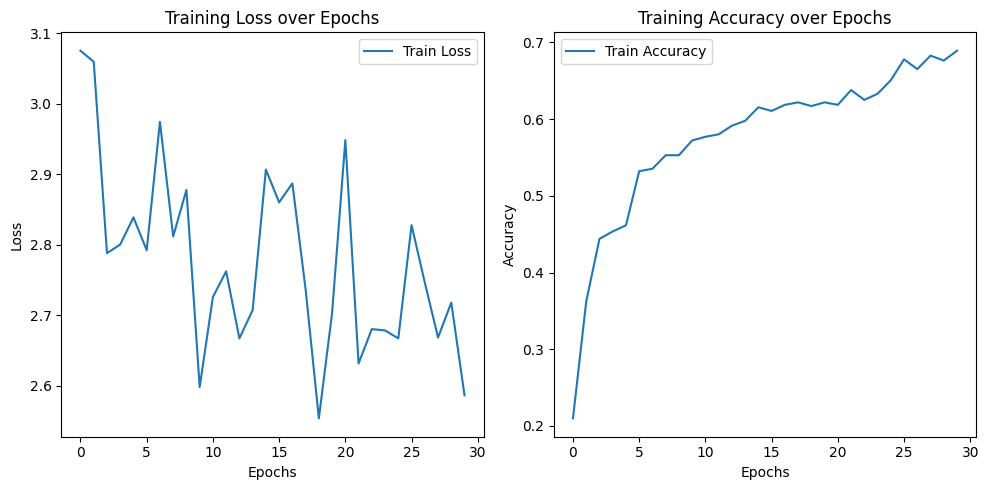

In [ ]:
# 학습 손실 그래프
plt.figure(figsize=(10, 5))

# 손실 그래프
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
### test_model
def test_model(model, test_loader, criterion):
    model.eval()

    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data, labels in test_loader:
            outputs = model(data.float())
            loss = criterion(outputs, labels.long())
            total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    average_loss = total_loss / len(test_loader)
    accuracy = 100 * correct_predictions / total_predictions

    print(f'Test Loss: {average_loss:.2f}, Test Accuracy: {accuracy:.2f}%')

    return average_loss, accuracy

# 모델 테스트
test_loss, test_acc = test_model(model, test_data, criterion)

Test Loss: 2.85, Test Accuracy: 48.85%
